# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\akash\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'''C:\Users\akash\ML\SUBMITTED ASSIGNMENT\mandatory\SVM\database.sqlite''') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:24<00:00, 3559.80it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [24]:
len(preprocessed_reviews)

87773

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

In [26]:
ProcessedSummary=[]
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    ProcessedSummary.append(sentance.strip())

 37%|███████████████████████████▌                                              | 32763/87773 [00:06<00:10, 5381.90it/s]C:\Users\akash\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▍                      | 61073/87773 [00:11<00:05, 5033.78it/s]C:\Users\akash\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 74%|███████████████████████████████████████████████████████                   | 65320/87773 [00:12<00:04, 5424.88it/s]C:\Users\akash\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle

## TRAIN TEST SPLIT

In [27]:
final["cleanedText"]=preprocessed_reviews
final["ProcessedSummary"]=ProcessedSummary
from sklearn.model_selection import train_test_split
D=final.iloc[:,[6,10,11]]
label=final.iloc[:,6]
#splitting into train test
train,test,labelsTrain,labelsTest=train_test_split(D,label,test_size=0.3)


xTrain=train["cleanedText"]
xTest=test["cleanedText"]
#taking summary data
sumTrain=train["ProcessedSummary"]
sumTest=test["ProcessedSummary"]

In [29]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText,ProcessedSummary
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,made china
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,dog lover delites
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,one fruitfly stuck
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,not work not waste money
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,big rip


# [4] Featurization

## [4.1] BAG OF WORDS

In [31]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,4), min_df=10)
count_vect.fit(xTrain)
final_bigram_counts =count_vect.transform(xTrain)
final_bigram_counts_test =count_vect.transform(xTest)
featuresBOW =count_vect.get_feature_names()
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 40020)
the number of unique words including both unigrams and bigrams  40020


In [33]:
#calculating length of every review
from scipy.sparse import hstack
lenxTrain=[]
for value in xTrain.values:
    lenxTrain.append(len(value))
lenxTest=[]
for value in xTest.values:
    lenxTest.append(len(value))
    
#taking summary data
sumTrain=train["ProcessedSummary"]
sumTest=test["ProcessedSummary"]

model=CountVectorizer(ngram_range=(1,3),min_df=10)
model.fit(sumTrain)
sparseBOWTrainSUMM=model.transform(sumTrain)
sparseBOWTestSUMM=model.transform(sumTest)
featuresBOWSUMM=model.get_feature_names()

#concatenating both of the sparse matrix
mergedTrain=hstack((final_bigram_counts, sparseBOWTrainSUMM))
mergedTest=hstack((final_bigram_counts_test,sparseBOWTestSUMM))

#concat. length as well
final_bigram_counts= hstack((mergedTrain,np.array(lenxTrain)[:,None]))
final_bigram_counts_test=hstack((mergedTest,np.array(lenxTest)[:,None]))

result=featuresBOW + featuresBOWSUMM
le=["reviewLENGTH"]
result+=le
print(len(result))

43195


## [4.3] TF-IDF

In [34]:
modelText=TfidfVectorizer(ngram_range=(1,4),min_df=10)
modelText.fit(xTrain)
sparseTFIDFTrain=modelText.transform(xTrain)
sparseTFIDFTest=modelText.transform(xTest)

#getting features
featuresTFIDF=modelText.get_feature_names()
print("total no. of features are")
print(len(featuresTFIDF))


#taking the summary data as well as the length of the reviews into consideration
modelS=TfidfVectorizer(ngram_range=(1,2),min_df=10)
modelS.fit(sumTrain)
sparseTFIDFTrainSUMM=modelS.transform(sumTrain)
sparseTFIDFTestSUMM=modelS.transform(sumTest)

#features of summary data
featuresSummaryTFIDF=modelS.get_feature_names()
print("total no of features from summary data are")
print(len(featuresSummaryTFIDF))

#concatenating both of the matrices(text and summary)
mergedTrain=hstack((sparseTFIDFTrain,sparseTFIDFTrainSUMM))
mergedTest=hstack((sparseTFIDFTest,sparseTFIDFTestSUMM))

#concatenating the length of the reviews
final_tf_idf_train=hstack((mergedTrain,np.array(lenxTrain)[:,None]))
final_tf_idf_test=hstack((mergedTest,np.array(lenxTest)[:,None]))

resultTfidf=featuresTFIDF+ featuresSummaryTFIDF
le=["reviewLENGTH"]
resultTfidf+=le
print(len(resultTfidf))

total no. of features are
40020
total no of features from summary data are
3034
43055


## [4.4] Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for x in xTest:
    list_of_sentance_test.append(x.split())
    
modelW2V=Word2Vec(list_of_sentance_train,min_count=5,size=50)
w2v_words=list(modelW2V.wv.vocab)

In [40]:
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for x in xTest:
    list_of_sentance_test.append(x.split())
    
#for train data
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = modelW2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

#for test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = modelW2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [01:16<00:00, 803.86it/s]


61441


100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:33<00:00, 782.17it/s]


In [41]:
w2v_words=list(modelW2V.wv.vocab)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

##### average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [42]:
#for train data
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = modelW2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))


100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [01:13<00:00, 830.89it/s]


61441


In [43]:
#for test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = modelW2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))


100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:33<00:00, 776.11it/s]


26332


#### [4.4.1.2] TFIDF weighted W2v

In [44]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
#model = TfidfVectorizer()
#tf_idf_matrix = model.fit_transform(preprocessed_reviews)
#tf_idf_matrix=final_tf_idf_train

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(resultTfidf,list(modelText.idf_)+list(modelS.idf_)))

In [45]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_feat=resultTfidf
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = modelW2V.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [22:32<00:00, 45.42it/s]


In [46]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = modelW2V.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [15:33<00:00, 25.62it/s]


# [5]  SVM

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
import scikitplot

In [62]:
param_grid={"alpha":[0.0001,0.001,0.01,0.1,1,10,100,1000],"penalty":["l1","l2"]}
alpha=[0.0001,0.001,0.01,0.1,1,10,100,1000]

## standardising the data

In [49]:
std=StandardScaler(with_mean=False)
std.fit_transform(final_bigram_counts)
final_bigram_counts=std.transform(final_bigram_counts)
final_bigram_counts_test=std.transform(final_bigram_counts_test)


### preparing model

In [50]:
modelBOW=GridSearchCV(SGDClassifier(loss="hinge"),param_grid,scoring="roc_auc")
modelBOW.fit(final_bigram_counts,labelsTrain)
modelBOW.best_estimator_

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

#### Error vs Hyperparameter

In [58]:
cvScore

0     0.886240
1     0.921117
2     0.834261
3     0.920686
4     0.725627
5     0.923736
6     0.555091
7     0.938930
8     0.500454
9     0.845283
10    0.500000
11    0.627262
12    0.500000
13    0.610338
Name: mean_test_score, dtype: float64

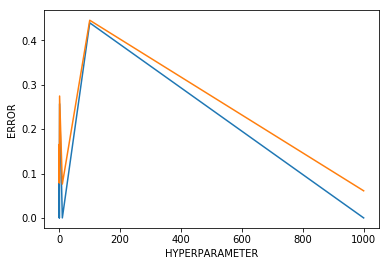

In [63]:
df=pd.DataFrame(modelBOW.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
#plotting
plt.plot(alpha,MSETrain[0:8])
plt.plot(alpha,MSECv[0:8])
plt.xlabel("HYPERPARAMETER")
plt.ylabel("ERROR")
plt.show()

## ROC curve

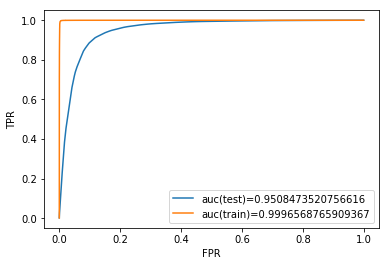

In [64]:
clf=CalibratedClassifierCV(base_estimator=modelBOW, method="isotonic", cv="prefit")
clf.fit(final_bigram_counts_test,labelsTest)
predTest=clf.predict(final_bigram_counts_test)
predTrain=clf.predict(final_bigram_counts)
pred=clf.predict_proba(final_bigram_counts_test)[:,1]
predProb=clf.predict_proba(final_bigram_counts)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


## confusion metrics for training data

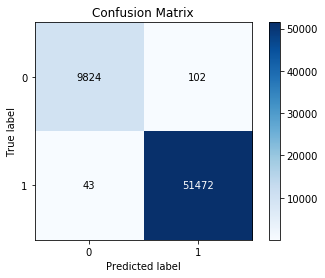

In [65]:

model=SGDClassifier(loss="hinge",alpha=0.1)
model.fit(final_bigram_counts,labelsTrain)
pred=model.predict(final_bigram_counts)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)

## confusion metrics for test data

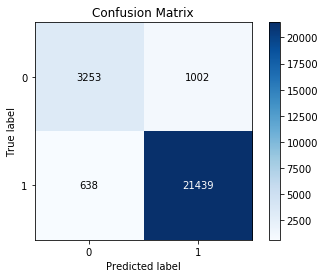

In [66]:
model=SGDClassifier(loss="hinge",alpha=0.1)
model.fit(final_bigram_counts,labelsTrain)
pred=model.predict(final_bigram_counts_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

## important features

In [54]:
clf=SGDClassifier(loss="hinge",alpha=0.1)
clf.fit(final_bigram_counts,labelsTrain)

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [55]:
positive=[]
negative=[]
def show_most_informative_features(result, clf, n=50):
    feature_names = result
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        negative.append(fn_1)
        positive .append(fn_2)
show_most_informative_features(resultTfidf,clf) 

## positive features

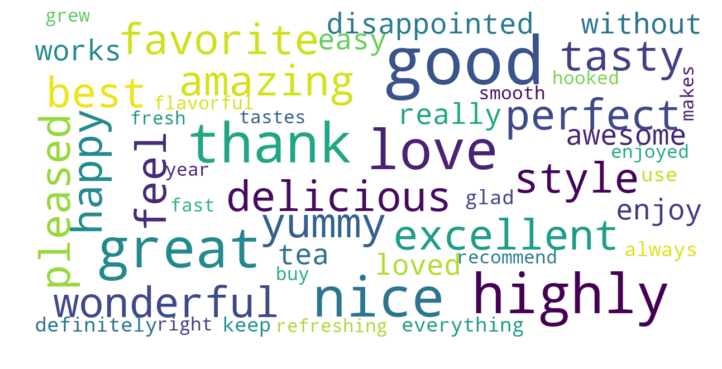

In [56]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud2 = WordCloud( background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(positive))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## negative features

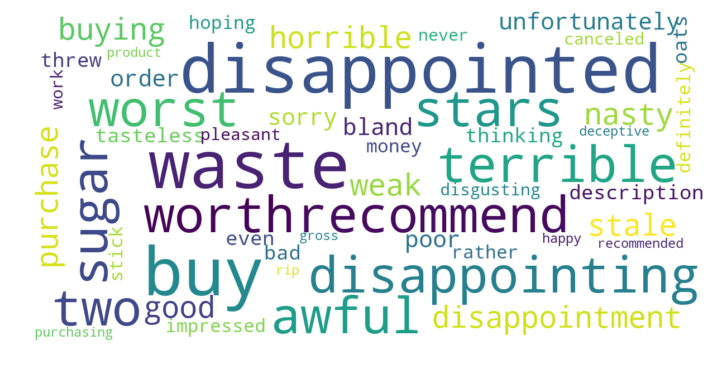

In [57]:
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(negative))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

## standardising the data

In [67]:
std=StandardScaler(with_mean=False)
std.fit_transform(final_tf_idf_train)
final_tfidf_train=std.transform(final_tf_idf_train)
final_tfidf_test=std.transform(final_tf_idf_test)

## preparing model

In [68]:
model=GridSearchCV(SGDClassifier(loss="hinge"),param_grid,scoring="roc_auc")
model.fit(final_tfidf_train,labelsTrain)
model.best_estimator_

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

## error vs hyperparameter

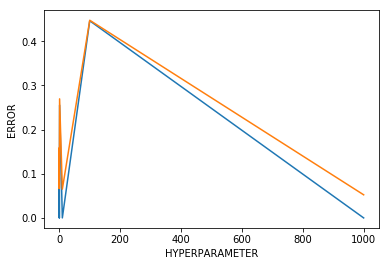

In [70]:
df=pd.DataFrame(model.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
#plotting
plt.plot(alpha,MSETrain[0:8])
plt.plot(alpha,MSECv[0:8])
plt.xlabel("HYPERPARAMETER")
plt.ylabel("ERROR")
plt.show()

## ROC curve

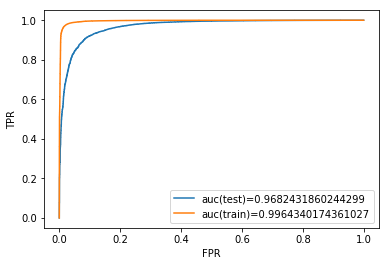

In [71]:
clf=CalibratedClassifierCV(base_estimator=model, method="sigmoid", cv="prefit")
clf.fit(final_tfidf_test,labelsTest)
predTest=clf.predict(final_tfidf_test)
predTrain=clf.predict(final_tfidf_train)
#predprob
pred=clf.predict_proba(final_tfidf_test)[:,1]
predProb=clf.predict_proba(final_tfidf_train)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


## confusion metrics for training data

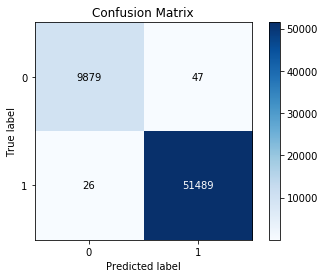

In [72]:
model=SGDClassifier(loss="hinge",alpha=0.1)
model.fit(final_tfidf_train,labelsTrain)
pred=model.predict(final_tfidf_train)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)

## confusion metrics for test data

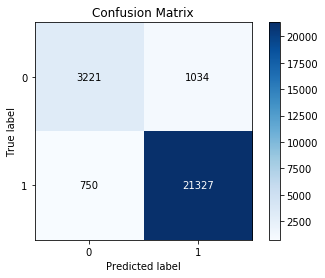

In [73]:
model=SGDClassifier(loss="hinge",alpha=0.1)
model.fit(final_tfidf_train,labelsTrain)
pred=model.predict(final_tfidf_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

## important features

In [64]:
clf=SGDClassifier(loss="hinge",alpha=0.1)
clf.fit(final_tfidf_train,labelsTrain)

positive=[]
negative=[]
def show_most_informative_features(result, clf, n=20):
    feature_names = result
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        negative.append(fn_1)
        positive .append(fn_2)
show_most_informative_features(result,clf) 

### positive features

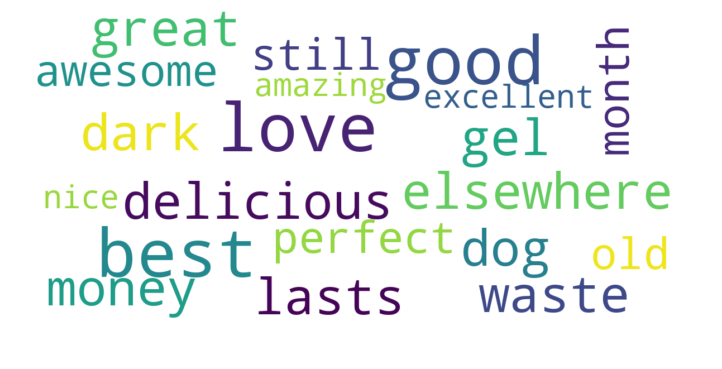

In [65]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(positive))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

### negative features

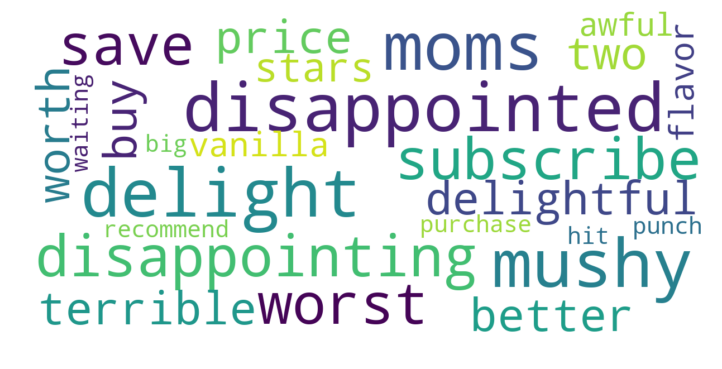

In [66]:
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(negative))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

## standardizing the data

In [74]:
std=StandardScaler(with_mean=False)
std.fit_transform(sent_vectors_train)
sent_vectors=std.transform(sent_vectors_train)
sent_vectors_test=std.transform(sent_vectors_test)

## preparing the model

In [75]:
#prep model
model=GridSearchCV(SGDClassifier(loss="hinge"),param_grid,scoring="roc_auc")
model.fit(sent_vectors,labelsTrain)
model.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

## error vs hyperparameter

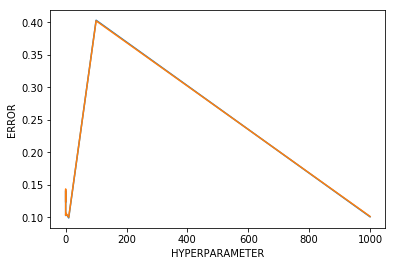

In [76]:
df=pd.DataFrame(model.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
#plotting
plt.plot(alpha,MSETrain[0:8])
plt.plot(alpha,MSECv[0:8])
plt.xlabel("HYPERPARAMETER")
plt.ylabel("ERROR")
plt.show()

## roc curve

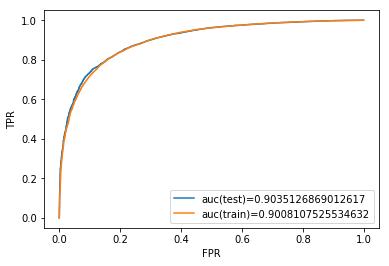

In [77]:
clf=CalibratedClassifierCV(base_estimator=model, method="sigmoid", cv="prefit")
clf.fit(sent_vectors_test,labelsTest)
predTest=clf.predict(sent_vectors_test)
predTrain=clf.predict(sent_vectors)
#predprob
pred=clf.predict_proba(sent_vectors_test)[:,1]
predProb=clf.predict_proba(sent_vectors)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## confusion metrics for training data

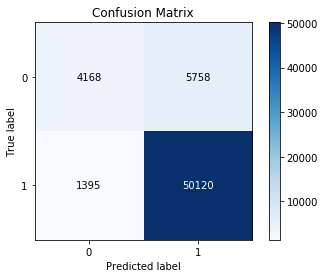

In [78]:
model=SGDClassifier(loss="hinge",alpha=0.01)
model.fit(sent_vectors,labelsTrain)
pred=model.predict(sent_vectors)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)

## confusion metrics for test data

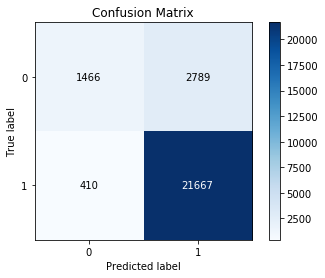

In [79]:
model=SGDClassifier(loss="hinge",alpha=0.01)
model.fit(sent_vectors,labelsTrain)
pred=model.predict(sent_vectors_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

## standardizing the data

In [80]:
std=StandardScaler(with_mean=False)
std.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_train =std.transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_test=std.transform(tfidf_sent_vectors_test)

## preparing model

In [81]:
#prep model
model=GridSearchCV(SGDClassifier(loss="hinge"),param_grid,scoring="roc_auc")
model.fit(tfidf_sent_vectors_train,labelsTrain)
model.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

## error vs hyperparameter

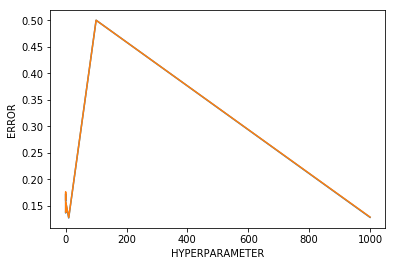

In [82]:
df=pd.DataFrame(model.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
#plotting
plt.plot(alpha,MSETrain[0:8])
plt.plot(alpha,MSECv[0:8])
plt.xlabel("HYPERPARAMETER")
plt.ylabel("ERROR")
plt.show()

## roc curve

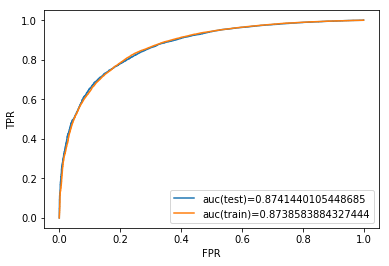

In [83]:
clf=CalibratedClassifierCV(base_estimator=model, method="sigmoid", cv="prefit")
clf.fit(tfidf_sent_vectors_test,labelsTest)
predTest=clf.predict(tfidf_sent_vectors_test)
predTrain=clf.predict(tfidf_sent_vectors_train)
#predprob
pred=clf.predict_proba(tfidf_sent_vectors_test)[:,1]
predProb=clf.predict_proba(tfidf_sent_vectors_train)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## confusion metrics for training data

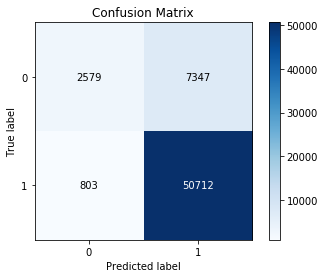

In [84]:
model=SGDClassifier(loss="hinge",alpha=0.01)
model.fit(tfidf_sent_vectors_train,labelsTrain)
pred=model.predict(tfidf_sent_vectors_train)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)

## confusion metrics for test data

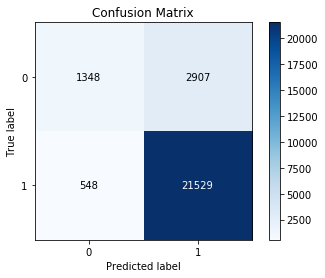

In [85]:
model=SGDClassifier(loss="hinge",alpha=0.01)
model.fit(tfidf_sent_vectors_train,labelsTrain)
pred=model.predict(tfidf_sent_vectors_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [86]:
final.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText,ProcessedSummary
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,made china


In [88]:
final=final.head(20000)


D=final.iloc[:,[6,10,11]]
label=final.iloc[:,6]
#splitting into train test
train,test,labelsTrain,labelsTest=train_test_split(D,label,test_size=0.3)



xTrain=train["cleanedText"]
xTest=test["cleanedText"]
#taking summary data
sumTrain=train["ProcessedSummary"]
sumTest=test["ProcessedSummary"]


#MODEL
count_vect = CountVectorizer(ngram_range=(1,4), min_df=10,max_features=400)
count_vect.fit(xTrain)
final_bigram_counts =count_vect.transform(xTrain)
final_bigram_counts_test =count_vect.transform(xTest)

#calculating length of every review
from scipy.sparse import hstack
lenxTrain=[]
for value in xTrain.values:
    lenxTrain.append(len(value))
lenxTest=[]
for value in xTest.values:
    lenxTest.append(len(value))
    
#taking summary data
sumTrain=train["ProcessedSummary"]
sumTest=test["ProcessedSummary"]

model=CountVectorizer(ngram_range=(1,3),min_df=10,max_features=100)
model.fit(sumTrain)
sparseBOWTrainSUMM=model.transform(sumTrain)
sparseBOWTestSUMM=model.transform(sumTest)

#concatenating both of the sparse matrix
mergedTrain=hstack((final_bigram_counts,sparseBOWTrainSUMM))
mergedTest=hstack((final_bigram_counts_test,sparseBOWTestSUMM))

#concat. length as well
final_bigram_counts= hstack((mergedTrain,np.array(lenxTrain)[:,None]))
final_bigram_counts_test=hstack((mergedTest,np.array(lenxTest)[:,None]))

#standardizing the data
std=StandardScaler(with_mean=False)
std.fit_transform(final_bigram_counts)
final_bigram_counts=std.transform(final_bigram_counts)
final_bigram_counts_test=std.transform(final_bigram_counts_test)


In [89]:
from sklearn.svm import SVC
#preparing model
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
param_distributions={"C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
RBFBOW=RandomizedSearchCV(SVC(kernel="rbf",probability=True),param_distributions,scoring="roc_auc")
RBFBOW.fit(final_bigram_counts,labelsTrain)
RBFBOW.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

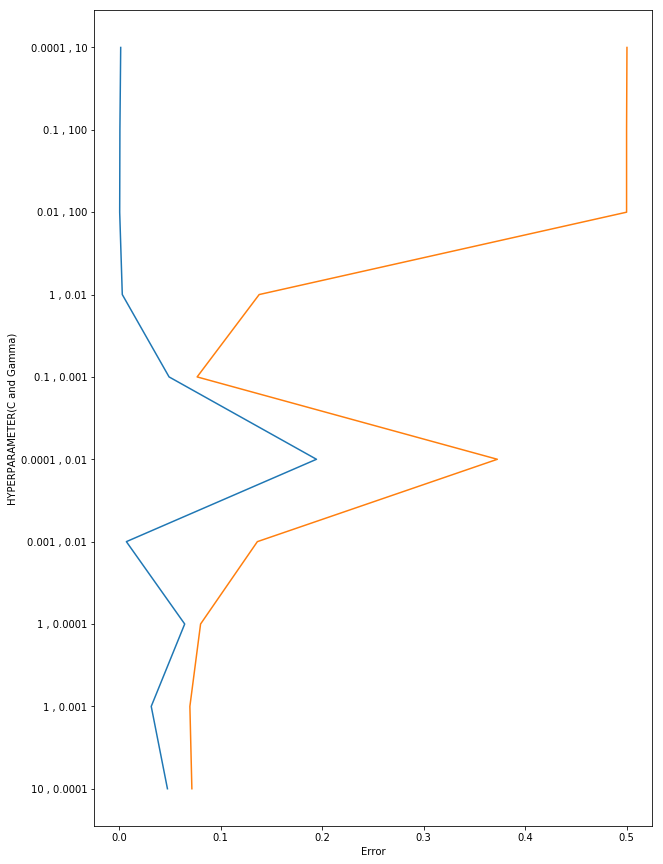

In [48]:
df=pd.DataFrame(RBFBOW.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
parameters=df["params"]
d=[]
for x in parameters:
    d.append("{} , {}".format(x["C"],x["gamma"]))
plt.figure(figsize=(10,15))
plt.plot(MSETrain,d)
plt.plot(MSECv,d)
plt.xlabel("Error")
plt.ylabel("HYPERPARAMETER(C and Gamma)")
plt.show()

## roc curve

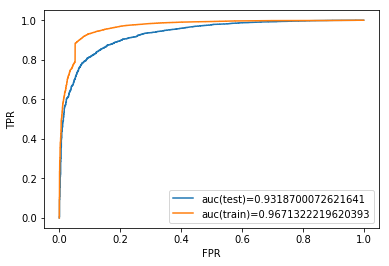

In [49]:
predTest=RBFBOW.predict(final_bigram_counts_test)
predTrain=RBFBOW.predict(final_bigram_counts)
#predprob
pred=RBFBOW.predict_proba(final_bigram_counts_test)[:,1]
predProb=RBFBOW.predict_proba(final_bigram_counts)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## confusion metrics 

### training data

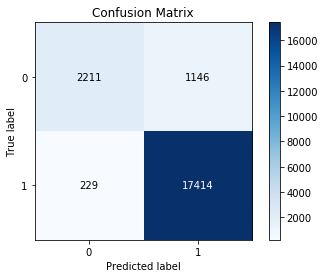

In [58]:
RBFBOW=SVC(kernel="rbf",gamma=0.001,C=1)
RBFBOW.fit(final_bigram_counts,labelsTrain)
pred=RBFBOW.predict(final_bigram_counts)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)

### test data

In [66]:
final_bigram_counts_test.shape

(9000, 501)

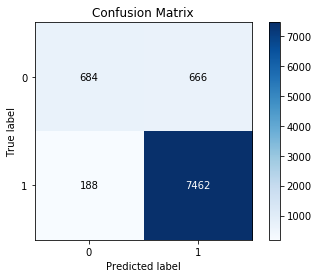

In [67]:
pred=RBFBOW.predict(final_bigram_counts_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [52]:
modelText=TfidfVectorizer(ngram_range=(1,4),min_df=10,max_features=400)
modelText.fit(xTrain)
sparseTFIDFTrain=modelText.transform(xTrain)
sparseTFIDFTest=modelText.transform(xTest)

#getting features
featuresTFIDF=modelText.get_feature_names()
print("total no. of features are")
print(len(featuresTFIDF))


#taking the summary data as well as the length of the reviews into consideration
modelS=TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=100)
modelS.fit(sumTrain)
sparseTFIDFTrainSUMM=modelS.transform(sumTrain)
sparseTFIDFTestSUMM=modelS.transform(sumTest)

#features of summary data
featuresSummaryTFIDF=modelS.get_feature_names()
print("total no of features from summary data are")
print(len(featuresSummaryTFIDF))

#concatenating both of the matrices(text and summary)
mergedTrain=hstack((sparseTFIDFTrain,sparseTFIDFTrainSUMM))
mergedTest=hstack((sparseTFIDFTest,sparseTFIDFTestSUMM))

#concatenating the length of the reviews
final_tf_idf_train=hstack((mergedTrain,np.array(lenxTrain)[:,None]))
final_tf_idf_test=hstack((mergedTest,np.array(lenxTest)[:,None]))

resultTfidf=featuresTFIDF+ featuresSummaryTFIDF
le=["reviewLENGTH"]
resultTfidf+=le
print(len(resultTfidf))

total no. of features are
400
total no of features from summary data are
100
501


In [54]:
RBFTFIDF=RandomizedSearchCV(SVC(kernel="rbf",probability=True),param_distributions,scoring="roc_auc")
RBFTFIDF.fit(final_tf_idf_train,labelsTrain)
RBFTFIDF.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

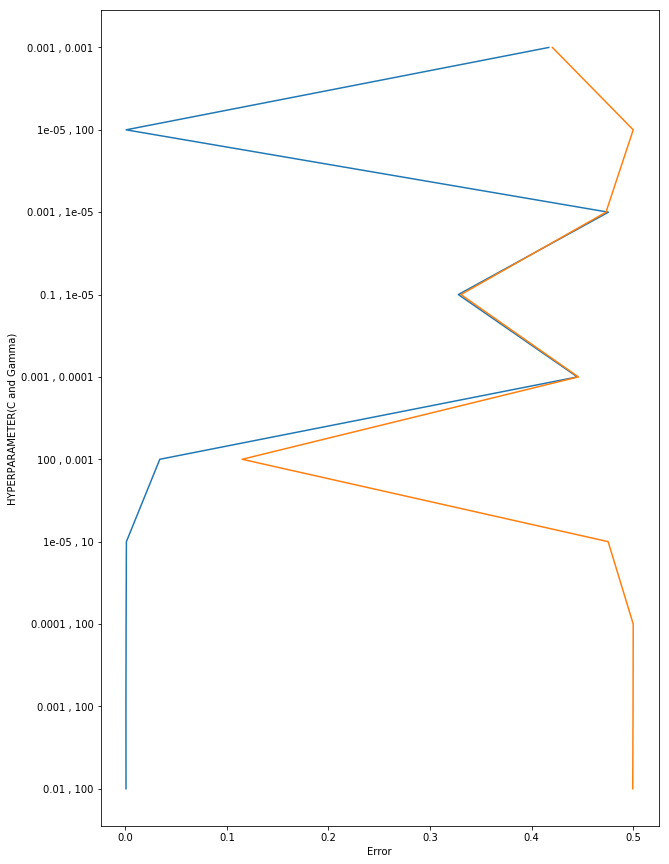

In [55]:
df=pd.DataFrame(RBFTFIDF.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
parameters=df["params"]
d=[]
for x in parameters:
    d.append("{} , {}".format(x["C"],x["gamma"]))
plt.figure(figsize=(10,15))
plt.plot(MSETrain,d)
plt.plot(MSECv,d)
plt.xlabel("Error")
plt.ylabel("HYPERPARAMETER(C and Gamma)")
plt.show()

## roc curve

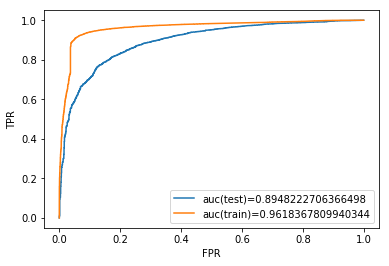

In [56]:
predTest=RBFTFIDF.predict(final_tf_idf_test)
predTrain=RBFTFIDF.predict(final_tf_idf_train)
#predprob
pred=RBFTFIDF.predict_proba(final_tf_idf_test)[:,1]
predProb=RBFTFIDF.predict_proba(final_tf_idf_train)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## confusion metrics

### for training data

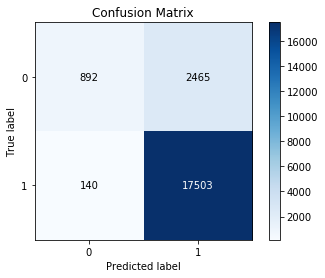

In [68]:
model=SVC(kernel="rbf",C=100,gamma=0.001)
model.fit(final_tf_idf_train,labelsTrain)
pred=model.predict(final_tf_idf_train)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)



### for test data

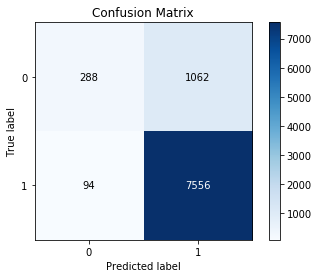

In [69]:
pred=model.predict(final_tf_idf_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [100]:
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for x in xTest:
    list_of_sentance_test.append(x.split())
    
#for train data
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = modelW2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

#for test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = modelW2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:32<00:00, 436.76it/s]


14000


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 445.91it/s]


In [72]:
RBFW2V=RandomizedSearchCV(SVC(kernel="rbf",probability=True),param_distributions,scoring="roc_auc")
RBFW2V.fit(sent_vectors_train,labelsTrain)
RBFW2V.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

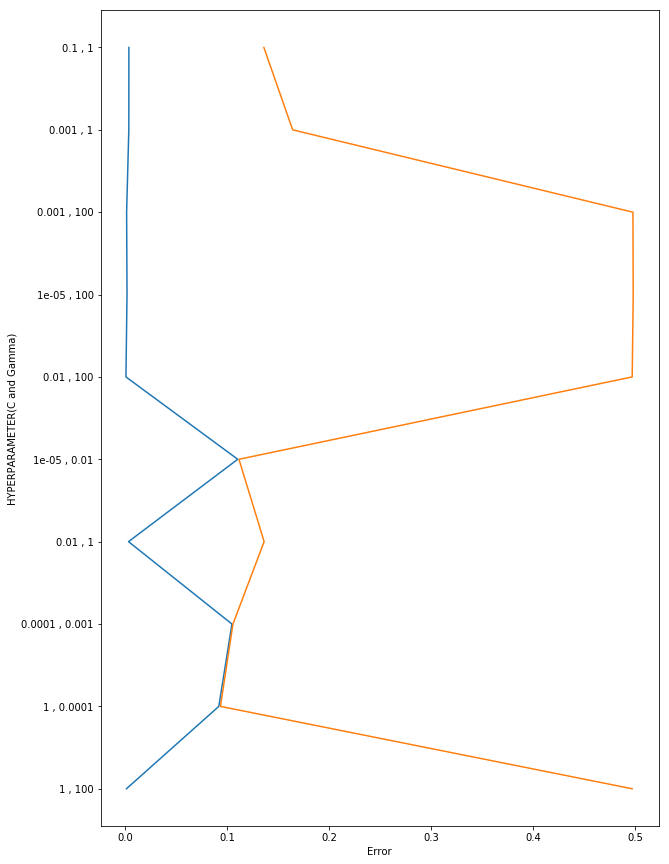

In [73]:
df=pd.DataFrame(RBFW2V.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
parameters=df["params"]
d=[]
for x in parameters:
    d.append("{} , {}".format(x["C"],x["gamma"]))
plt.figure(figsize=(10,15))
plt.plot(MSETrain,d)
plt.plot(MSECv,d)
plt.xlabel("Error")
plt.ylabel("HYPERPARAMETER(C and Gamma)")
plt.show()

In [76]:
len(sent_vectors_test)

9000

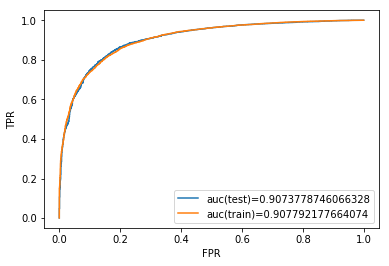

In [78]:
predTest=RBFW2V.predict(sent_vectors_test)
predTrain=RBFW2V.predict(sent_vectors_train)
#predprob
pred=RBFW2V.predict_proba(sent_vectors_test)[:,1]
predProb=RBFW2V.predict_proba(sent_vectors_train)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## confusion metrics for training data

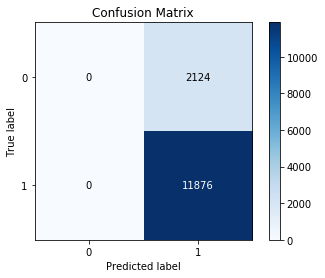

In [101]:
model=SVC(kernel="rbf",C=1,gamma=0.0001)
model.fit(sent_vectors_train,labelsTrain)
pred=model.predict(sent_vectors_train)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)

## confusion metrics for test data

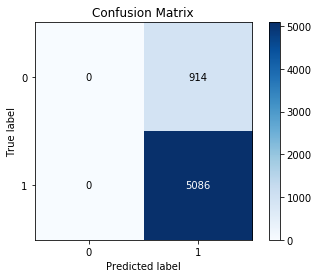

In [102]:
pred=model.predict(sent_vectors_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [103]:
modelText=TfidfVectorizer(ngram_range=(1,4),min_df=10,max_features=500)
modelText.fit(xTrain)
sparseTFIDFTrain=modelText.transform(xTrain)
sparseTFIDFTest=modelText.transform(xTest)

#getting features
featuresTFIDF=modelText.get_feature_names()
print("total no. of features are")
print(len(featuresTFIDF))

#taking the summary data as well as the length of the reviews into consideration
modelS=TfidfVectorizer(ngram_range=(1,2),min_df=10)
modelS.fit(sumTrain)
sparseTFIDFTrainSUMM=modelS.transform(sumTrain)
sparseTFIDFTestSUMM=modelS.transform(sumTest)

#features of summary data
featuresSummaryTFIDF=modelS.get_feature_names()
print("total no of features from summary data are")
print(len(featuresSummaryTFIDF))

#concatenating both of the matrices(text and summary)
mergedTrain=hstack((sparseTFIDFTrain,sparseTFIDFTrainSUMM))
mergedTest=hstack((sparseTFIDFTest,sparseTFIDFTestSUMM))

#concatenating the length of the reviews
final_tf_idf_train=hstack((mergedTrain,np.array(lenxTrain)[:,None]))
final_tf_idf_test=hstack((mergedTest,np.array(lenxTest)[:,None]))

resultTfidf=featuresTFIDF+ featuresSummaryTFIDF
le=["reviewLENGTH"]
resultTfidf+=le
print(len(resultTfidf))

total no. of features are
500
total no of features from summary data are
809
1310


In [104]:
dictionary = dict(zip(resultTfidf,list(modelText.idf_)+list(modelS.idf_)))

tfidf_feat=resultTfidf
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = modelW2V.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = modelW2V.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:17<00:00, 339.32it/s]


In [81]:
RBFTFIDFW2V=RandomizedSearchCV(SVC(kernel="rbf",probability=True),param_distributions,scoring="roc_auc")
RBFTFIDFW2V.fit(tfidf_sent_vectors_train,labelsTrain)
RBFTFIDFW2V.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

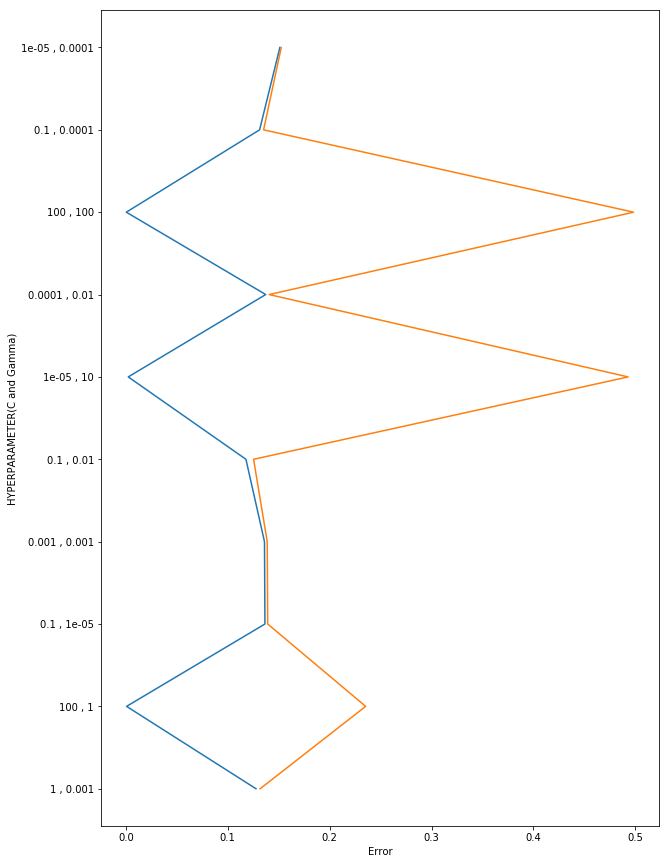

In [82]:
df=pd.DataFrame(RBFTFIDFW2V.cv_results_)
trainScore=df["mean_train_score"]
cvScore=df["mean_test_score"]
MSETrain=[1-x for x in trainScore]
MSECv=[1-x for x in cvScore]
parameters=df["params"]
d=[]
for x in parameters:
    d.append("{} , {}".format(x["C"],x["gamma"]))
plt.figure(figsize=(10,15))
plt.plot(MSETrain,d)
plt.plot(MSECv,d)
plt.xlabel("Error")
plt.ylabel("HYPERPARAMETER(C and Gamma)")
plt.show()

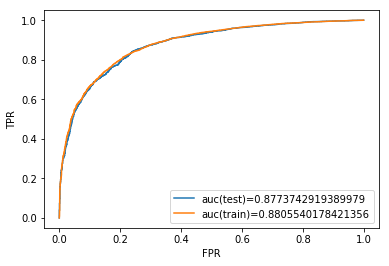

In [83]:
predTest=RBFTFIDFW2V.predict(tfidf_sent_vectors_test)
predTrain=RBFTFIDFW2V.predict(tfidf_sent_vectors_train)
#predprob
pred=RBFTFIDFW2V.predict_proba(tfidf_sent_vectors_test)[:,1]
predProb=RBFTFIDFW2V.predict_proba(tfidf_sent_vectors_train)[:,1]
#test
fpr,tpr,_= roc_curve(labelsTest,pred)
auc=roc_auc_score(labelsTest,pred)
plt.plot(fpr,tpr,label="auc(test)="+str(auc))
plt.legend(loc=4)
#train
fpr,tpr,_= roc_curve(labelsTrain,predProb)
auc=roc_auc_score(labelsTrain,predProb)
plt.plot(fpr,tpr,label="auc(train)="+str(auc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## confusion metrics for training data

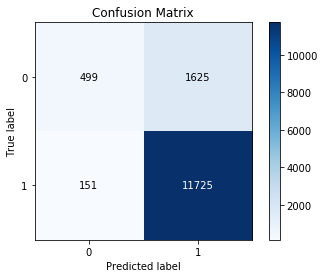

In [105]:
model=SVC(kernel="rbf",C=100,gamma=0.001)
model.fit(tfidf_sent_vectors_train,labelsTrain)
pred=model.predict(tfidf_sent_vectors_train)
scikitplot.metrics.plot_confusion_matrix(labelsTrain,pred)



## confusion metrics for test data

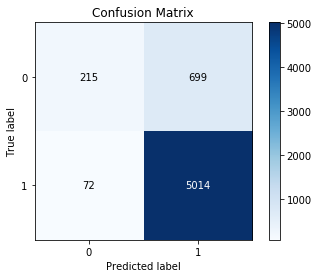

In [106]:
pred=model.predict(tfidf_sent_vectors_test)
scikitplot.metrics.plot_confusion_matrix(labelsTest,pred)

# [6] Conclusions

## BOW

In [95]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Kernel","C","alpha","gamma", "roc score(train)","roc score(test)","best regular."]
x.add_row(["linear","--", "0.1","--","99.9%","95%","L2"])
x.add_row(["rbf","100","--","0.0001","96","93","L2"])
print(x)
print("="*50)

+--------+-----+-------+--------+------------------+-----------------+---------------+
| Kernel |  C  | alpha | gamma  | roc score(train) | roc score(test) | best regular. |
+--------+-----+-------+--------+------------------+-----------------+---------------+
| linear |  -- |  0.1  |   --   |      99.9%       |       95%       |       L2      |
|  rbf   | 100 |   --  | 0.0001 |        96        |        93       |       L2      |
+--------+-----+-------+--------+------------------+-----------------+---------------+


## TFIDF

In [97]:
x = PrettyTable()
x.field_names = ["Kernel","C","alpha","gamma", "roc score(train)","roc score(test)","best regular."]
x.add_row(["linear","--", "1","--","99.6%","96.8%","L2"])
x.add_row(["rbf","100","--","0.001","96.1","89.4","L2"])
print(x)

+--------+-----+-------+-------+------------------+-----------------+---------------+
| Kernel |  C  | alpha | gamma | roc score(train) | roc score(test) | best regular. |
+--------+-----+-------+-------+------------------+-----------------+---------------+
| linear |  -- |   1   |   --  |      99.6%       |      96.8%      |       L2      |
|  rbf   | 100 |   --  | 0.001 |       96.1       |       89.4      |       L2      |
+--------+-----+-------+-------+------------------+-----------------+---------------+


## avgW2V

In [98]:
x = PrettyTable()
x.field_names = ["Kernel","C","alpha","gamma", "roc score(train)","roc score(test)","best regular."]
x.add_row(["linear","--", "0.01","--","90.08%","96.8%","L2"])
x.add_row(["rbf","1","--","0.0001","90.77","90.73","L2"])
print(x)

+--------+----+-------+--------+------------------+-----------------+---------------+
| Kernel | C  | alpha | gamma  | roc score(train) | roc score(test) | best regular. |
+--------+----+-------+--------+------------------+-----------------+---------------+
| linear | -- |  0.01 |   --   |      90.08%      |      96.8%      |       L2      |
|  rbf   | 1  |   --  | 0.0001 |      90.77       |      90.73      |       L2      |
+--------+----+-------+--------+------------------+-----------------+---------------+


## tfidf weighted W2V

In [99]:
x = PrettyTable()
x.field_names = ["Kernel","C","alpha","gamma", "roc score(train)","roc score(test)","best regular."]
x.add_row(["linear","--", "0.01","--","87.3%","87.4%","L2"])
x.add_row(["rbf","0.1","--","0.01","88%","87.7","L2"])
print(x)

+--------+-----+-------+-------+------------------+-----------------+---------------+
| Kernel |  C  | alpha | gamma | roc score(train) | roc score(test) | best regular. |
+--------+-----+-------+-------+------------------+-----------------+---------------+
| linear |  -- |  0.01 |   --  |      87.3%       |      87.4%      |       L2      |
|  rbf   | 0.1 |   --  |  0.01 |       88%        |       87.7      |       L2      |
+--------+-----+-------+-------+------------------+-----------------+---------------+
